In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_set=torchvision.datasets.MNIST(
    root='./data/MNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

test_set=torchvision.datasets.MNIST(
    root='./data/MNIST'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 46.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.88MB/s]


In [10]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,drop_last=True)
testloader = torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=False,drop_last=True)

In [11]:
sample=next(iter(train_set))

image=sample[0]
label=sample[1]

image.shape

torch.Size([1, 28, 28])

In [12]:
batch = next(iter(trainloader))
images, labels = batch
images.shape

torch.Size([64, 1, 28, 28])

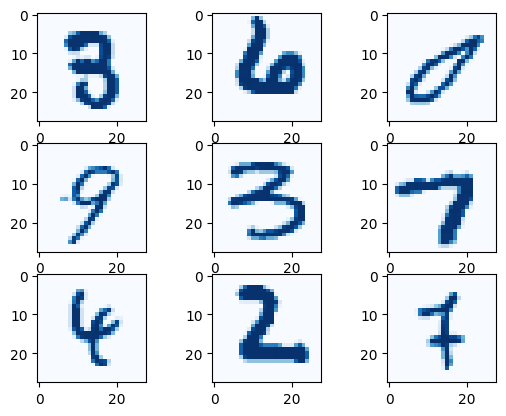

In [13]:
n = 9
for index in range(1, n + 1):
    plt.subplot(3,3, index)
    plt.imshow(images[index].numpy().squeeze(), cmap='Blues')

In [14]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.fc1=nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2=nn.Linear(in_features=120,out_features=60)
        self.out=nn.Linear(in_features=60,out_features=10)

    def forward(self,t):
        t=F.relu(self.conv1(t))
        t=F.max_pool2d(t,kernel_size=2,stride=2)

        t=F.relu(self.conv2(t))
        t=F.max_pool2d(t,kernel_size=2,stride=2)

        t=F.relu(self.fc1(t.reshape(-1,12*4*4)))
        t=F.relu(self.fc2(t))
        t=self.out(t)
        return t

In [15]:
network = Network()

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

In [16]:
network.cpu()
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(64,1, 28, 28))
        labels = Variable(labels)

        outputs = network(train)

        loss = error(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(64,1, 28, 28))
                outputs = network(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.16854214668273926, Accuracy: 95.80328369140625%
Iteration: 1000, Loss: 0.16733573377132416, Accuracy: 97.99679565429688%
Iteration: 1500, Loss: 0.0241728313267231, Accuracy: 98.42748260498047%
Iteration: 2000, Loss: 0.008608648553490639, Accuracy: 97.93669891357422%
Iteration: 2500, Loss: 0.09715121984481812, Accuracy: 98.46754455566406%
Iteration: 3000, Loss: 0.07627639174461365, Accuracy: 98.48757934570312%
Iteration: 3500, Loss: 0.05676939710974693, Accuracy: 98.68790435791016%
Iteration: 4000, Loss: 0.04633574187755585, Accuracy: 98.6678695678711%
Iteration: 4500, Loss: 0.07388429343700409, Accuracy: 98.73798370361328%
